In [14]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl
import matplotlib.pyplot as plt

In [242]:
class SVMModel:
    
    def linear_kernel(self,x1, x2):
        return np.dot(x1, x2)

    def polynomial_kernel(self,x, y, p=2):
        return (1 + np.dot(x, y)) ** p

    def gaussian_kernel(self,x, y, sigma=100):
        return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

    def fit(self, X, y, kernel, C):
        n_samples, n_features = X.shape

        # Gram matrix
        # initialize kernel matrix    
        K = np.zeros((n_samples, n_samples))
        # Kernel matrix

        for i in range(n_samples):
            for j in range(n_samples):
                if kernel == 'linear_kernel':
                    K[i,j] = self.linear_kernel(X[i], X[j])
                elif kernel == 'polynomial_kernel':
                    K[i,j] = self.polynomial_kernel(X[i], X[j])
                else:
                    K[i,j] = self.gaussian_kernel(X[i], X[j])


        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv_idx = a > 1e-5
        ind = np.arange(len(a))[sv_idx]
        a = a[sv_idx]    
        sv = X[sv_idx]
        sv_y = y[sv_idx]
        print("%d support vectors out of %d points" % (len(a), n_samples))

        # Intercept
        b = 0
        for n in range(len(a)):
            b += sv_y[n]
            b -= np.sum(a * sv_y * K[ind[n],sv_idx])
        b /= len(a)

        # Weight vector
        if kernel == 'linear_kernel':
            w = np.zeros(n_features)
            for n in range(len(a)):
                w += a[n] * sv_y[n] * sv[n]
        else:
            w = None
        return sv, sv_y, a, w, b

    def project(self,X, kernel,sv, sv_y, a, w, b):
        if w is not None:
            return np.dot(X, w) + b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a_val, sv_y_val, sv_val in zip(a, sv_y, sv):
                    if kernel == 'polynomial_kernel':
                        s += a_val * sv_y_val * self.polynomial_kernel(X[i], sv_val)
                    else:
                        s += a_val * sv_y_val * self.gaussian_kernel(X[i], sv_val)
                y_predict[i] = s
            return y_predict + b

    def predict(self,X, kernel, sv, sv_y, a, w, b):
        return np.sign(self.project(X, kernel,sv, sv_y, a, w, b))
    
    def plot_contour(self,X1_train, X2_train, kernel, sv, sv_y, a, w, b):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(sv[:,0], sv[:,1], s=100, c="g")
        # here we choose the range between -7 and 7 as we have choosen
        # the mean to be between -4 and 4 while generating data with the variance of 0.8
        X1, X2 = np.meshgrid(np.linspace(-7,7,50), np.linspace(-7,7,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = self.project(X, kernel,sv, sv_y, a, w, b).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

In [249]:
# Generate data for class 1

mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100
cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
X1 = np.random.multivariate_normal(mean= mu_1, cov=cov_mat, size = num_sample)
#X1[0] = np.array([8,8])

# Generate data for class 2

angle = np.random.uniform(0, 2*np.pi, num_sample)
d =  np.random.normal(np.square(3*sigma_1),np.square(.5*sigma_1),num_sample)
X2 = np.array([X1[:,0] + d*np.cos(angle), X1[:,1] + d*np.sin(angle)]).T

# Combine X1 and X2 into single dataset

X = np.concatenate([X1, X2],axis = 0)
y = np.append(-np.ones(num_sample),np.ones(num_sample))

In [256]:
mean1 = np.array([0, 2])
mean2 = np.array([2, 0])
cov = np.array([[1.8, 1.6], [1.6, 1.8]])
X1 = np.random.multivariate_normal(mean1, cov, 100)
X2 = np.random.multivariate_normal(mean2, cov, 100)

X = np.concatenate([X1, X2],axis = 0)
y = np.append(-np.ones(len(X1)),np.ones(len(X2)))

In [257]:
SVM = SVMModel()

kernel = 'polynomial_kernel'

sv, sv_y, a, w, b = SVM.fit(X,y,kernel=kernel,C=None)

     pcost       dcost       gap    pres   dres
 0: -1.5950e+01 -2.9014e+01  6e+02  2e+01  2e+00
 1: -1.5686e+01 -8.3074e+00  2e+02  6e+00  5e-01
 2: -6.9210e+00 -1.5838e+00  1e+01  5e-01  4e-02
 3: -1.6994e+00 -1.2139e+00  2e+00  7e-02  5e-03
 4: -1.1493e+00 -1.0680e+00  5e-01  2e-02  2e-03
 5: -9.5425e-01 -1.0483e+00  1e-01  1e-03  9e-05
 6: -1.0387e+00 -1.0399e+00  2e-03  1e-05  9e-07
 7: -1.0398e+00 -1.0398e+00  2e-05  1e-07  9e-09
 8: -1.0398e+00 -1.0398e+00  2e-07  1e-09  9e-11
Optimal solution found.
5 support vectors out of 200 points


In [258]:
y_pred

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

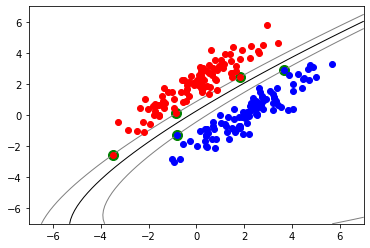

In [259]:
SVM.plot_contour(X1, X2, kernel, sv, sv_y, a, w, b)

In [262]:
resolution = 200
x_series = np.linspace(-15,15,resolution)
y_series = np.linspace(-15,15,resolution)

x_mesh,y_mesh = np.meshgrid(x_series,y_series)

x_mesh = x_mesh.reshape(-1,1)
y_mesh = y_mesh.reshape(-1,1)

mesh = np.append(x_mesh,y_mesh,axis=1)
y_pred = SVM.predict(mesh,kernel,sv,sv_y,a,w,b).astype(int)

x_mesh = x_mesh.reshape(resolution,resolution)
y_mesh = y_mesh.reshape(resolution,resolution)
y_pred = y_pred.reshape(resolution,resolution)

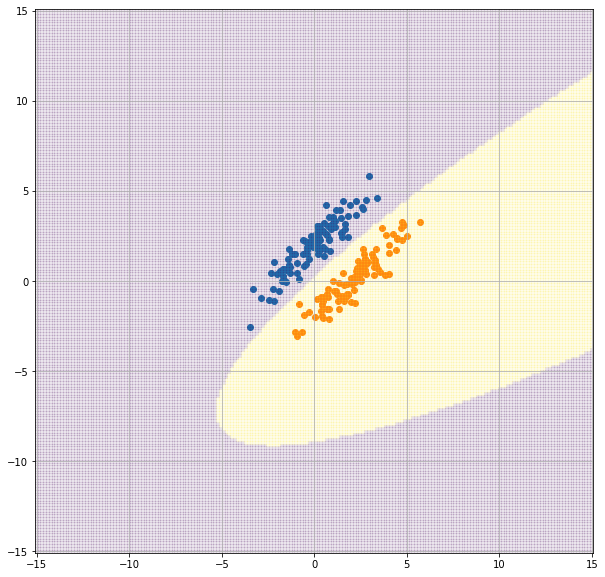

In [263]:
plt.figure(figsize=(10,10))
plt.scatter(X1[:,0],X1[:,1])
plt.scatter(X2[:,0],X2[:,1])
plt.pcolormesh(x_mesh,y_mesh,y_pred,cmap='viridis',shading='auto',alpha=0.1)
plt.grid(True)